In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dense,Flatten,BatchNormalization,Dropout,MaxPooling2D

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import L1
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import resnet50 as resnet_50

In [2]:
classe_dict = {
0:"airplane" ,
1:"automobile" ,
2:"bird" ,
3:"cat" ,
4:"deer",
5:"dog" ,
6:"frog" ,
7:"horse",
8:"ship",
9:"truck",
}

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.10,random_state = 42)

170498071/170498071 [==============================] - 13s 0us/step


In [4]:
x_train = np.array([cv2.resize(i,(64,64),interpolation = cv2.INTER_AREA) for i in x_train])
x_val  = np.array([cv2.resize(i,(64,64),interpolation = cv2.INTER_AREA) for i in x_val])
X_test  = np.array([cv2.resize(i,(64,64),interpolation = cv2.INTER_AREA) for i in x_test])

In [5]:
X_test = X_test/255.0

In [6]:
y_train = to_categorical(y_train,10)
y_val = to_categorical(y_val,10)
y_test = to_categorical(y_test,10)

In [7]:
input_shape = x_train[0].shape
no_of_classes = 10

#set the input shape of base model equal to 64*64*3
basemodel = resnet_50.ResNet50(include_top=False,weights='imagenet',input_shape=input_shape,classes=no_of_classes)

print(f"Basemodel Input shape{basemodel.input_shape}")
print(f"Basemodel output shape{basemodel.output_shape}")

94765736/94765736 [==============================] - 4s 0us/step
Basemodel Input shape(None, 64, 64, 3)
Basemodel output shape(None, 2, 2, 2048)


In [8]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [9]:
conv2_block3_output = basemodel.get_layer('conv2_block3_out').output

In [10]:
## Perform batch Normalisation and Flatten the output
x= BatchNormalization()(conv2_block3_output)
x = Flatten()(x)

#Adding the Dense layers

x = Dense(512,activation=('relu'))(x)
x = Dense(256,activation=('relu'))(x)
output = Dense(no_of_classes,activation=('softmax'))(x)
#This is the classification layer

In [11]:
model = Model(inputs=basemodel.input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [12]:
for layer in basemodel.layers:
    layer.trainable = False

In [13]:
opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss=CategoricalCrossentropy(),metrics=['accuracy'])

In [14]:
no_of_epochs = 20
batch_size = 64


train_datagen = ImageDataGenerator(horizontal_flip=True,rescale=1.0/255)
train_datagen.fit(x_train)
train_datagenerator = train_datagen.flow(x_train,y_train,batch_size=batch_size)

In [15]:
val_datagen = ImageDataGenerator(horizontal_flip=True,rescale=1.0/255)
val_datagen.fit(x_val)
val_datagenerator = val_datagen.flow(x_val,y_val,batch_size=batch_size)

In [16]:
train_steps_per_epoch = x_train.shape[0]//batch_size
val_steps_per_epoch = x_val.shape[0]//batch_size

hist = model.fit(train_datagenerator,steps_per_epoch=train_steps_per_epoch,validation_data=val_datagenerator,
                 validation_steps=val_steps_per_epoch,epochs=no_of_epochs,verbose=1)

Epoch 1/20
703/703 [==============================] - 22s 25ms/step - loss: 1.7443 - accuracy: 0.4021 - val_loss: 1.4246 - val_accuracy: 0.5136
Epoch 2/20
703/703 [==============================] - 16s 23ms/step - loss: 1.4069 - accuracy: 0.5087 - val_loss: 1.3521 - val_accuracy: 0.5250
Epoch 3/20
703/703 [==============================] - 16s 23ms/step - loss: 1.2966 - accuracy: 0.5479 - val_loss: 1.3076 - val_accuracy: 0.5385
Epoch 4/20
703/703 [==============================] - 16s 23ms/step - loss: 1.2530 - accuracy: 0.5614 - val_loss: 1.2893 - val_accuracy: 0.5471
Epoch 5/20
703/703 [==============================] - 17s 24ms/step - loss: 1.2059 - accuracy: 0.5782 - val_loss: 1.1765 - val_accuracy: 0.5745
Epoch 6/20
703/703 [==============================] - 17s 24ms/step - loss: 1.1865 - accuracy: 0.5847 - val_loss: 1.2171 - val_accuracy: 0.5687
Epoch 7/20
703/703 [==============================] - 16s 23ms/step - loss: 1.1623 - accuracy: 0.5939 - val_loss: 1.1931 - val_accuracy:

In [17]:
model.save("cifar10_resnet50_Model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
scores = model.evaluate(X_test,y_test)

print(f"Test Accuracy {np.round(scores[1]*100,2)}%")

313/313 [==============================] - 2s 7ms/step - loss: 1.0937 - accuracy: 0.6216
Test Accuracy 62.16%


In [19]:
## Add our dense layers
x= BatchNormalization()(conv2_block3_output)
x = Flatten()(x)

#Adding the Dense layers
x = Dense(1024,activation=('relu'))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512,activation=('relu'))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(256,activation=('relu'))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
output_1= Dense(no_of_classes,activation=('softmax'))(x)
#This is the classification layer

model_1 = Model(inputs=basemodel.input, outputs=output_1)
model_1.summary()

opt = Adam(learning_rate=0.0001)

model_1.compile(optimizer=opt,loss=CategoricalCrossentropy(),metrics=['accuracy'])
hist_1 = model_1.fit(train_datagenerator,steps_per_epoch=train_steps_per_epoch,validation_data=val_datagenerator,
                 validation_steps=val_steps_per_epoch,epochs=no_of_epochs,verbose=1)
# model_1.save("cifar10_vgg16_rev_1.h5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 32, 32, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [20]:
model_1.save("cifar10_renet50_Model2.h5")

In [21]:
scores_1 = model_1.evaluate(X_test,y_test)
print(f"Test Accuracy {np.round(scores_1[1]*100,2)}%")

313/313 [==============================] - 2s 7ms/step - loss: 0.8995 - accuracy: 0.7072
Test Accuracy 70.72%


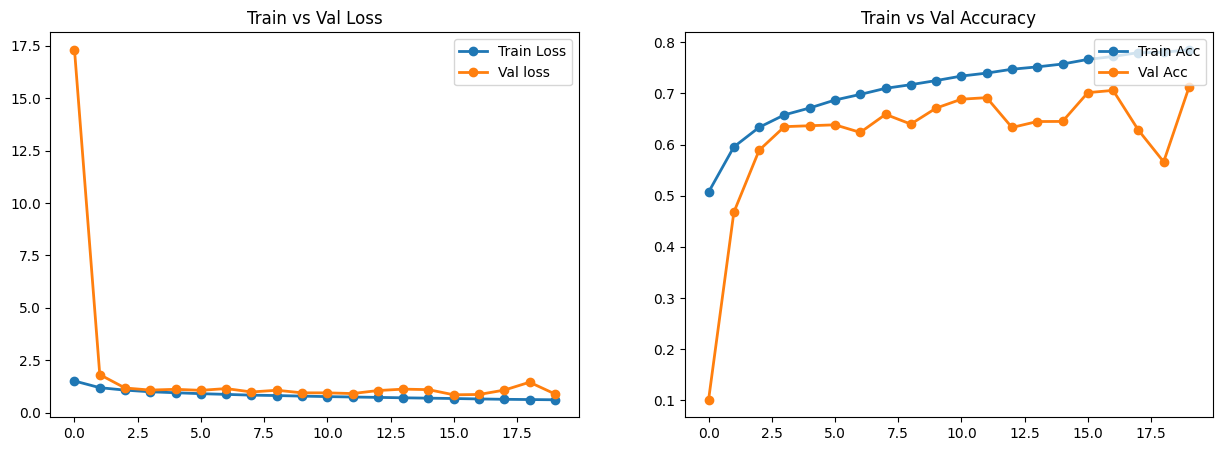

In [22]:
train_loss = hist_1.history["loss"]
val_loss = hist_1.history["val_loss"]

train_acc = hist_1.history["accuracy"]
val_acc = hist_1.history["val_accuracy"]

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(list(range(no_of_epochs)),train_loss,marker='o',linewidth=2)
plt.plot(list(range(no_of_epochs)),val_loss,marker='o',linewidth=2)
plt.title("Train vs Val Loss")
plt.legend(["Train Loss", "Val loss"],loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(list(range(no_of_epochs)),train_acc,marker='o',linewidth=2)
plt.plot(list(range(no_of_epochs)),val_acc,marker='o',linewidth=2)
plt.title("Train vs Val Accuracy")
plt.legend(["Train Acc", "Val Acc"],loc = 'upper right')

plt.show()

In [23]:
predictions = model_1.predict(X_test)
y_pred = np.argmax(predictions,axis =1)

y_true = np.argmax(y_test,axis =1)

313/313 [==============================] - 3s 6ms/step


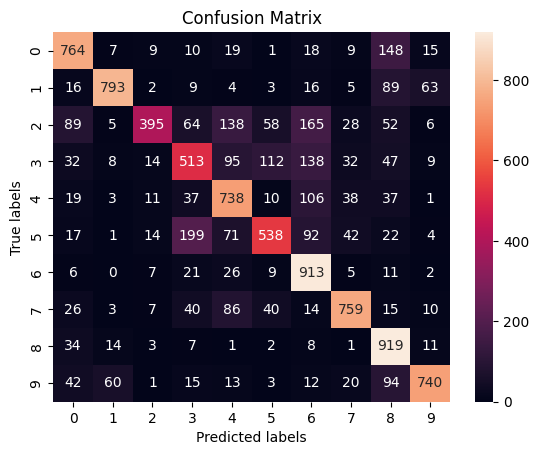

In [24]:
cm = confusion_matrix(y_true,y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

In [25]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1000
           1       0.89      0.79      0.84      1000
           2       0.85      0.40      0.54      1000
           3       0.56      0.51      0.54      1000
           4       0.62      0.74      0.67      1000
           5       0.69      0.54      0.61      1000
           6       0.62      0.91      0.74      1000
           7       0.81      0.76      0.78      1000
           8       0.64      0.92      0.76      1000
           9       0.86      0.74      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.73      0.71      0.70     10000
weighted avg       0.73      0.71      0.70     10000



In [26]:
def display_image(X_test, indexes, y_true,y_pred):

    # plot first few images
    plt.figure(figsize=(12,12))

    for i in range(len(indexes)):

        # Get image data
        img = X_test[indexes[i]]

        # Get predicted label
        predicted_label = y_pred[indexes[i]]

        # Get true label
        true_label = y_true[indexes[i]]
        true_class_label = classe_dict[true_label]



        # define subplot
        plt.subplot(330 + 1 + i)
        plt.title('Preicted Label: %s \n'%predicted_label+\
                 'True Label: %s\n'%true_label+\
                  'True Class: %s\n'%true_class_label,
                 fontsize=18)
        # plot raw pixel data
        plt.imshow(img)

    plt.subplots_adjust(bottom = 0.001)  # the bottom of the subplots of the figure
    plt.subplots_adjust(top = 0.99)
    # show the figure
    plt.show()

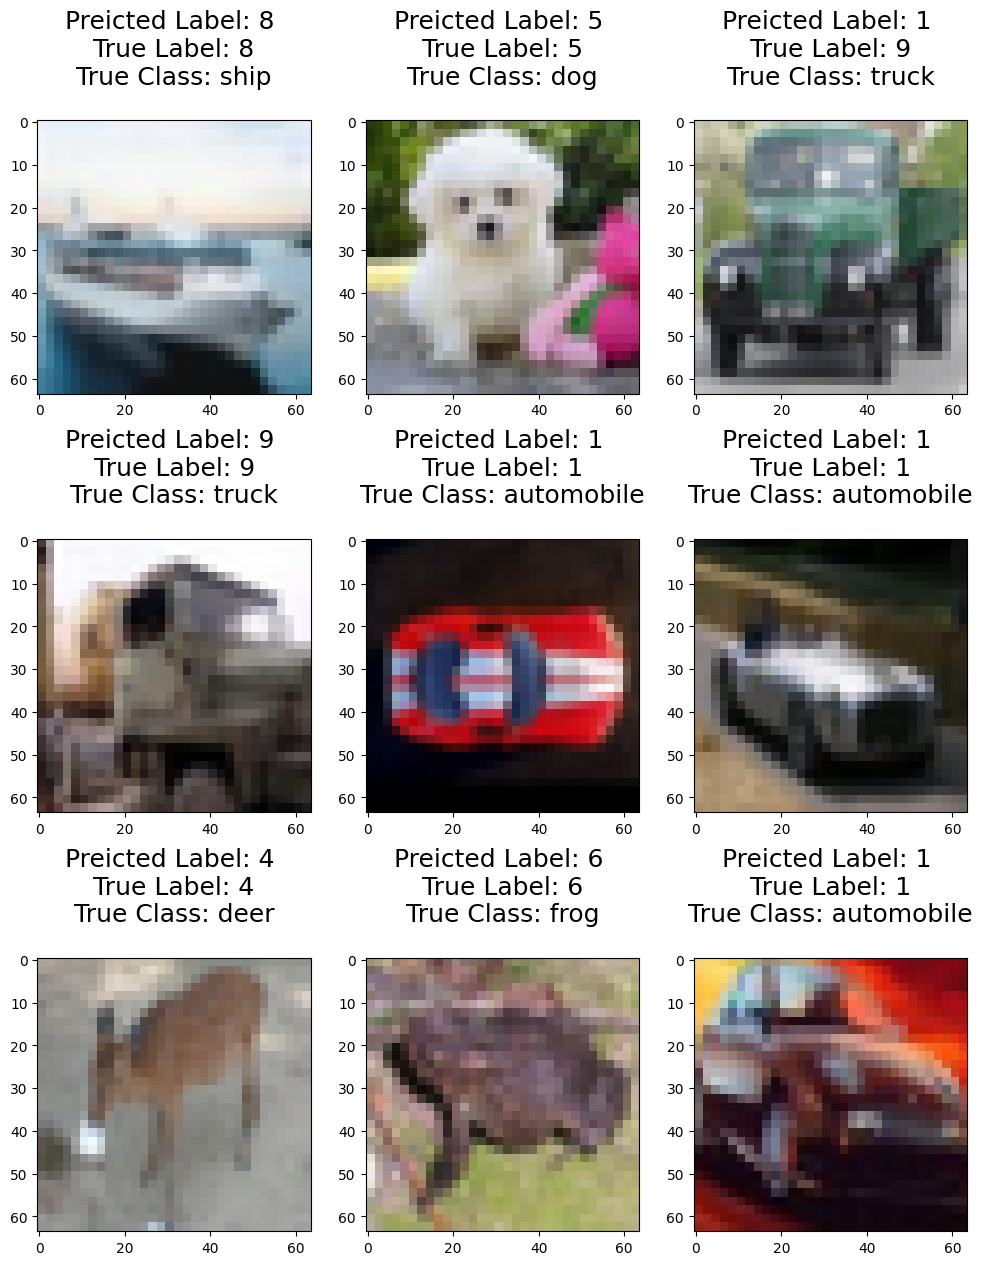

In [27]:
# plotting random images
# their true and predicted labels
no_of_images = 9
indexes = [random.randint(0,len(X_test)) for i in range(no_of_images)]
display_image(X_test,indexes,y_true,y_pred)